# Spatial clustering of cell niches using `CellCharter`

We cluster cells based on their cellular niches using `CellCharter` (<https://github.com/CSOgroup/cellcharter>).

In [1]:
import squidpy as sq
import cellcharter as cc
import scanpy as sc
import os
from lightning.pytorch import seed_everything
seed_everything(0)

/home/zwanghc/anaconda3/envs/cellcharter/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zwanghc/anaconda3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


0

In [2]:
DATA_PATH = "/import/home/share/zw/data/breast_cancer"

In [3]:
method = "UCS_10X"
adata_st = sc.read_h5ad(os.path.join(DATA_PATH, "paper_data/downstream_xenium_breast_cancer/scVI_output", method, "annotated_adata_st.h5ad"))

In [4]:
adata_st

AnnData object with n_obs × n_vars = 165734 × 307
    obs: 'tech', '_scvi_batch', '_scvi_labels', 'celltype_scanvi', 'C_scANVI'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'tech_colors'
    obsm: 'X_mde_scanvi', 'X_scANVI', 'X_scVI', 'X_scVI_mde', 'spatial'
    layers: 'counts'

In [5]:
sq.gr.spatial_neighbors(adata_st, coord_type='generic', delaunay=True)
cc.gr.remove_long_links(adata_st)

In [6]:
cc.gr.aggregate_neighbors(adata_st, n_layers=3, use_rep='X_scANVI')

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


In [7]:
gmm = cc.tl.Cluster(
    n_clusters=20, 
    random_state=12345,
    # If running on GPU
    trainer_params=dict(accelerator='gpu', devices=1)
)

In [8]:
# model_params = {
#     'random_state': 20250213,
#     'trainer_params': {
#         'accelerator':'gpu',
#         'devices': 1,
#         'enable_progress_bar': False
#     },
# }
# gmm = cc.tl.ClusterAutoK(
#     n_clusters=(17,30), 
#     model_class=cc.tl.GaussianMixture,
#     model_params=model_params,
#     max_runs=5,
# )

In [9]:
gmm.fit(adata_st, use_rep='X_cellcharter')
adata_st.obs['spatial_cluster'] = gmm.predict(adata_st, use_rep='X_cellcharter')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s, nll=-152.]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.67it/s] 


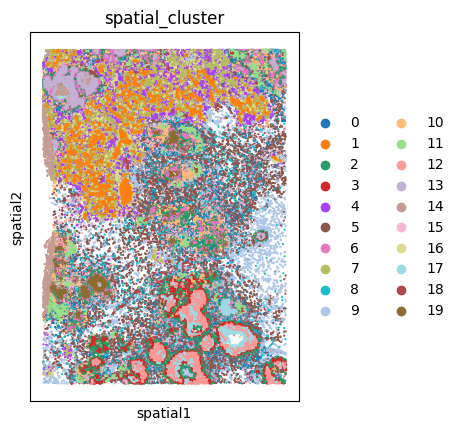

In [14]:
sc.pl.spatial(
    adata_st,
    color='spatial_cluster', 
    spot_size=50.,
)

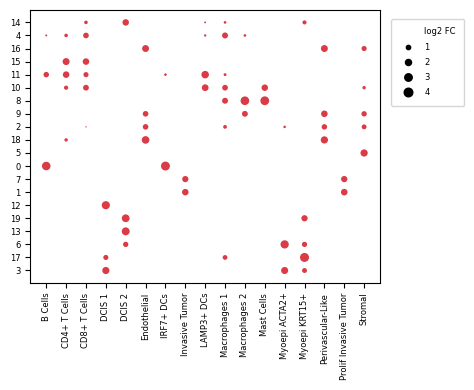

In [11]:
cc.gr.enrichment(adata_st, group_key='spatial_cluster', label_key='C_scANVI')
cc.pl.enrichment(adata_st, group_key='spatial_cluster', label_key='C_scANVI', figsize=(4,4), fontsize=6, dot_scale=1)

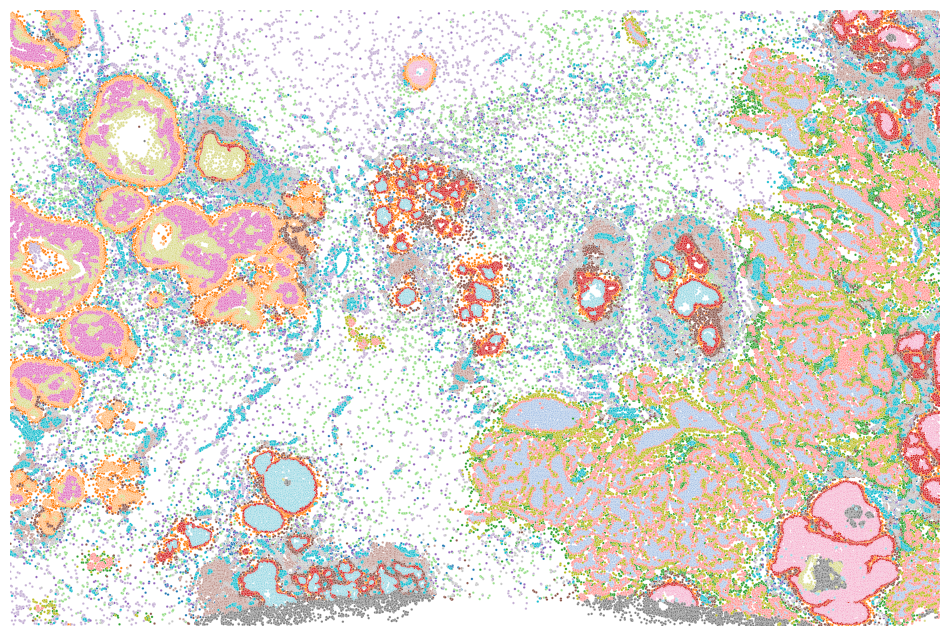

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import tifffile
import pandas as pd

mask = tifffile.imread(os.path.join(DATA_PATH, "UCS_10X.tif"))

# reset style
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.ylim(0, mask.shape[0])
plt.xlim(mask.shape[1], 0)

# Sorted by cell type
plot_df = pd.DataFrame(adata_st.obsm['spatial'], columns=['center_x', 'center_y'])
plot_df['spatial_cluster'] = adata_st.obs['spatial_cluster'].values
plot_df = plot_df.sort_values(by='spatial_cluster')
# Selected Endothelial and invasive Tumor / Prolif Invasive Tumor
# plot_df = plot_df[plot_df['C_scANVI'].isin(["DCIS 1", "DCIS 2", "Invasive Tumor", "Prolif Invasive Tumor", "T Cell & Tumor Hybrid", "Myoepi ACTA2+", "Myoepi KRT15+"])]
# Change color
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['spatial_cluster'], s=3, palette='tab20')
plt.legend('', frameon=False)
# No axis
plt.axis('off')
plt.savefig("/import/home/share/zw/pql/results/breast_cancer/CellCharter.png", format='png', bbox_inches='tight')
plt.show()